# Data Processing

In [19]:
from statistics import median
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib as mpl
import seaborn as sb

feature_list_xlsx = ["CZA","CZB","CZD","CZH","CZM","CZV","PMC","TRF"]
feature_list_csv = ["EDU","MHI","new_housing","Public_Assistance_Rate","median_gross_rent","median_monthly_housing_costs",
"perc_below_poverty", "perc_college_grad","perc_hs_grad","perc_insured","perc_rental_housing","unemployment","vacancies","work_travel_time"]
path = os.path.join(os.getcwd(),'data_clean')
feature_values = pd.read_excel(os.path.join(path,'TRF_2016.xlsx'))
geoid = feature_values['GEOID']
dataframes = {}

# Read in feature values
for year in range(2016, 2020):
    df_dict = {}
    df_dict['GEOID'] = geoid
    df_dict['YEAR'] = year
    for feature in feature_list_xlsx:
        file_name = feature + "_" + str(year) + '.xlsx'
        feature_values = pd.read_excel(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-5]]
    for feature in feature_list_csv:
        file_name = feature + "_" + str(year) + '.csv'
        feature_values = pd.read_csv(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-4]]
    dataframes[year] = pd.DataFrame(df_dict)

feature_values = pd.concat(dataframes.values(), ignore_index=True)
feature_values = feature_values.apply(pd.to_numeric, errors='coerce')

# Read in house values
house_values = pd.read_csv(os.path.join(path,'home_value.csv'))
renamed_geoid = []
for row in house_values['GEOID']:
    tract_num = (row.split(',')[0]).replace("Census Tract ",'')
    if ('.' in tract_num):
        if len(tract_num) == 6:
            tract_num = '0' + tract_num
        tract_num = '17031' + tract_num.replace('.','')
    else:
        if len(tract_num) == 3:
            tract_num = '0' + tract_num
        tract_num = '17031' + tract_num + '00'
    renamed_geoid.append(int(tract_num))

house_values['GEOID'] = renamed_geoid

# Create dataframe of feature and outcome values
df = pd.merge(house_values, feature_values, on=['YEAR','GEOID'])
col_dict = {'CZA': 'violent_crime',"CZB":"burglary","CZD":"drug_abuse",'CZH': 'aggravated_assault', "CZM": "major_crime", 
'CZV': 'homicide',"PMC":"pollution", 'TRF': 'traffic_intensity', 'EDU': 'college_enrolled','MHI': 'household_income', 
"Public_Assistance_Rate":"public_assistance","vacancies":"housing_vacancies"}

feature_list = col_dict.values()
# feature_list = feature_list_xlsx + feature_list_csv

df = df.rename(columns = col_dict)
print(df)

            GEOID  YEAR  house_value  violent_crime  burglary  drug_abuse  \
0     17031010100  2016       230700           21.0      20.0        13.0   
1     17031010201  2016       151100           23.0      26.0         9.0   
2     17031010202  2016       133300           13.0      10.0        14.0   
3     17031010300  2016       189100            9.0      15.0         4.0   
4     17031010400  2016       215200           15.0      20.0         5.0   
...           ...   ...          ...            ...       ...         ...   
3136  17031843500  2019       178700           18.0      10.0        13.0   
3137  17031843600  2019       266500            4.0      20.0         5.0   
3138  17031843700  2019       499700            9.0       0.0         6.0   
3139  17031843800  2019       171900           47.0       4.0        10.0   
3140  17031843900  2019       105700            9.0       0.0       106.0   

      aggravated_assault  major_crime  homicide  pollution  ...  \
0       

# Summary Statistics

In [20]:
df = df.drop('GEOID',1)
print(df.head())
print(df.describe())
print(df.dtypes)

   YEAR  house_value  violent_crime  burglary  drug_abuse  aggravated_assault  \
0  2016       230700           21.0      20.0        13.0                 1.0   
1  2016       151100           23.0      26.0         9.0                 2.0   
2  2016       133300           13.0      10.0        14.0                 0.0   
3  2016       189100            9.0      15.0         4.0                 1.0   
4  2016       215200           15.0      20.0         5.0                 1.0   

   major_crime  homicide  pollution  traffic_intensity  ...  \
0        153.0      34.0  11.449365           0.795343  ...   
1        157.0      49.0  11.507208          12.009642  ...   
2        296.0      47.0  11.494258          10.433684  ...   
3        139.0      29.0  11.482891           8.353382  ...   
4        140.0      28.0  11.521601          17.952882  ...   

   median_gross_rent  median_monthly_housing_costs  perc_below_poverty  \
0              872.0                         942.0          

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [21]:
print(df.dtypes)

YEAR                              int64
house_value                       int64
violent_crime                   float64
burglary                        float64
drug_abuse                      float64
aggravated_assault              float64
major_crime                     float64
homicide                        float64
pollution                       float64
traffic_intensity               float64
college_enrolled                float64
household_income                float64
new_housing                     float64
public_assistance               float64
median_gross_rent               float64
median_monthly_housing_costs    float64
perc_below_poverty              float64
perc_college_grad               float64
perc_hs_grad                    float64
perc_insured                    float64
perc_rental_housing             float64
unemployment                    float64
housing_vacancies               float64
work_travel_time                float64
dtype: object


The dataframe comprises 2557 observations, where each observation contains the median house value (outcome variable) and 9 feature variables for a given census tract and year. The variables will be split 80:20, so that 80% of the data is in the training dataset and 20% is in the testing dataset.

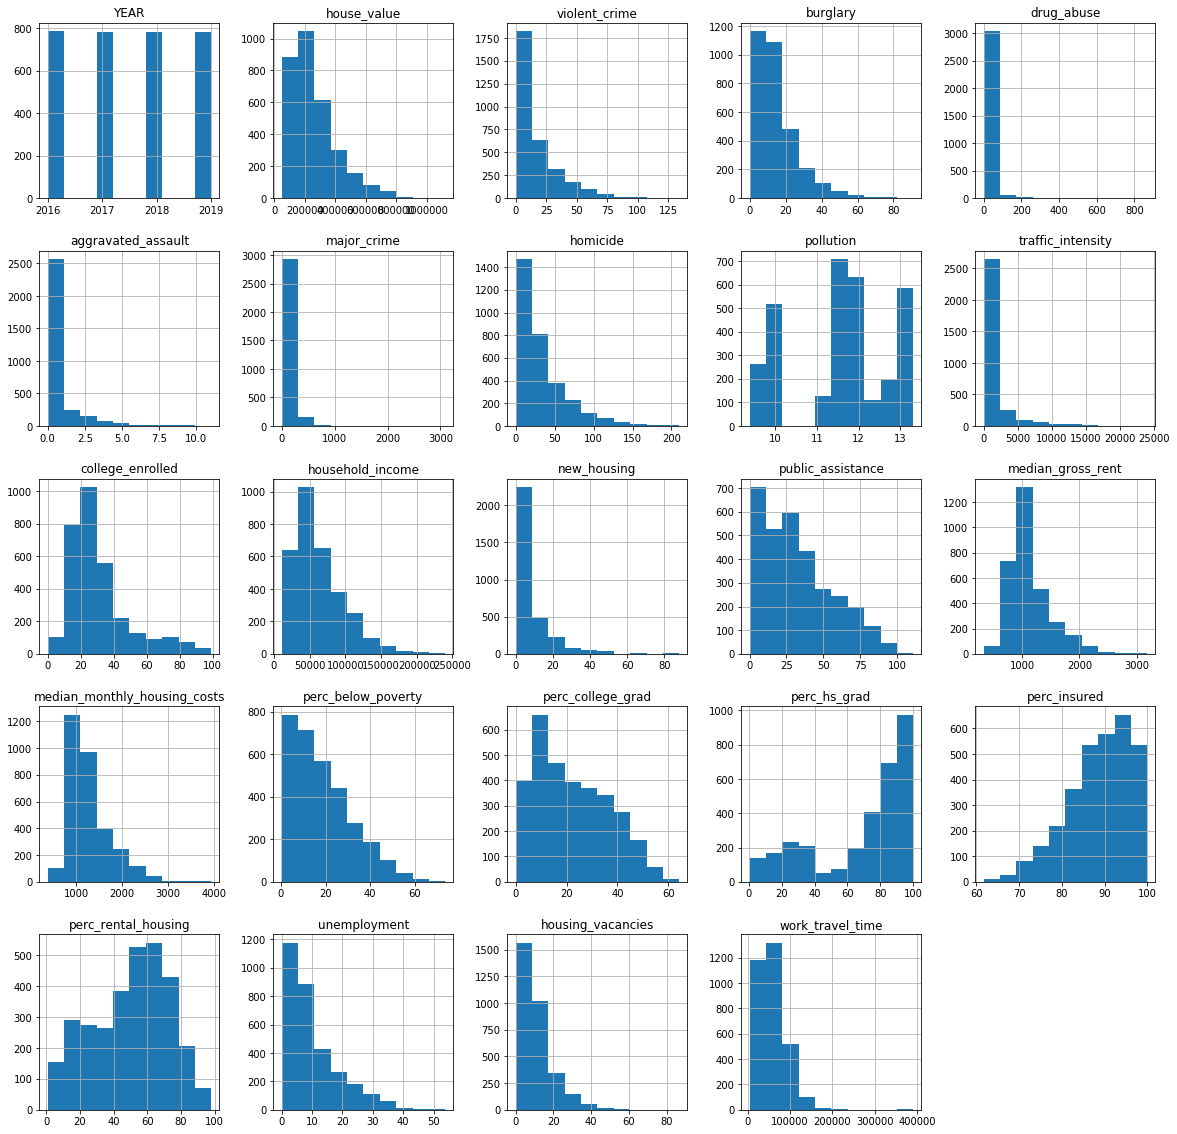

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize=(20,20))
plt.show()

From plotting the distribution of the feature values, we observe that features vary significantly in scale, so we will be normalizing the feature parameters. We can also observe that features such as assault and traffic instensity are significantly skewed with most values being in the lowest value bucket, as such, we have concerns that there may no be enough variation in those features to be valuable for the model. We fortunately do not observe any outliers that would need to be excluded.

house_value                     1.000000
perc_college_grad               0.700609
household_income                0.619706
median_monthly_housing_costs    0.617900
median_gross_rent               0.533147
perc_insured                    0.405057
college_enrolled                0.350445
new_housing                     0.330086
traffic_intensity               0.163557
perc_hs_grad                    0.144458
work_travel_time                0.136069
YEAR                            0.091675
major_crime                     0.004359
perc_rental_housing            -0.035412
pollution                      -0.095575
housing_vacancies              -0.109767
drug_abuse                     -0.201749
burglary                       -0.220524
aggravated_assault             -0.330054
homicide                       -0.371188
violent_crime                  -0.424887
perc_below_poverty             -0.466653
public_assistance              -0.487759
unemployment                   -0.549840
Name: house_valu

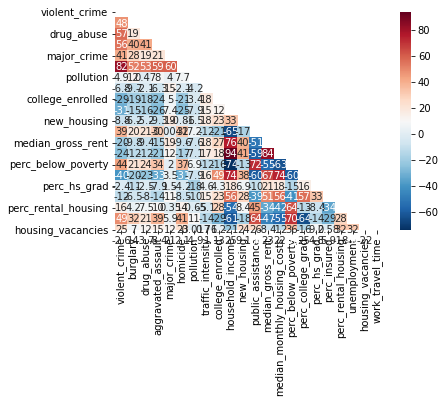

In [23]:
corr_matrix = df.corr()
print(corr_matrix["house_value"].sort_values(ascending=False))
mask = np.zeros_like(df.iloc[:,2:].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(df.iloc[:,2:].corr()*100, cmap='RdBu_r', annot = True, mask=mask)

Based on the heat map of the correlations of features, we can see that there is a positive correlation between housing price and median household income for an area, as well as the percent of the population enrolled in college. We can also observe a strong negative correlation between household price and unemployment levels and crime levels in the area. There is strong correlation between the crime features, which my make it worth combining them into a single feature.

# Feature Engineering

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop('house_value', 1)
y = df['house_value']

imputer = SimpleImputer(strategy="median")

# Replace NA feature values with feature median
for feature in feature_list:
    col_ave = X[feature].median()
    X[feature].fillna(value = col_ave, inplace = True)

# Convert categorical variables to factors
X['YEAR'], _ = pd.factorize(df['YEAR'], sort=True)

# Attempted combining variables, but models did not change from collapsing crime measures, and deterioriated from collapsing crime and poverty measures
# Collapse crime and poverty measures into one variable each
# X['crime_rate'] = X['violent_crime'] + X['aggravated_assault'] + X['homicide']
# X = X.drop(['violent_crime','aggravated_assault','homicide'],1)

# X['poverty_index'] = X['poverty_rate'] + X['rental_rate'] + X['unemploy_rate']
# X = X.drop(['poverty_rate','rental_rate','unemploy_rate'],1)

#feature_list = ['traffic_intensity', 'college_rate','household_income','poverty_rate','rental_rate','unemploy_rate','crime_rate']

# Scale all features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_trans = (num_pipeline.fit_transform(X))

train_x, test_x, train_y, test_y = train_test_split(X_trans, y.to_numpy(), test_size=0.2, random_state=123)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Model Training

### Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
lin_predictions = lin_reg.predict(train_x) 
lin_mse = mean_squared_error(train_y, lin_predictions)  
lin_rmse = np.sqrt(lin_mse) 
print(lin_rmse)
#print(mean_absolute_error(train_y, lin_predictions))

# Cross validation
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

90228.47916039645
Scores: [104861.48042687  83455.67757475  99540.70768439  82808.06468309
  91307.57116165  82297.24258588  96075.89909118  87383.22391417
  97509.59111156  87553.30327258]
Mean: 91279.27615061213
Standard deviation: 7464.997542009276


### Decision Trees

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=123)
tree_reg.fit(train_x, train_y)
dt_predictions = tree_reg.predict(train_x)
scores = cross_val_score(tree_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [101767.05718734  80406.55919703  97814.84480661  90867.92964215
 110663.35584417  91880.41335652  76875.79883302  95869.72796997
  95209.91946715  92133.73118631]
Mean: 93348.93374902623
Standard deviation: 9214.52077662369


### Support Vector Machine

In [27]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_x, train_y)
svm_predictions = svm_reg.predict(train_x)
svm_mse = mean_squared_error(train_y, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

146016.5651511496

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=123)
forest_reg.fit(train_x, train_y)
rf_predictions = forest_reg.predict(train_x) 
forest_mse = mean_squared_error(train_y, rf_predictions) 
forest_rmse = np.sqrt(forest_mse) 
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

23805.59085545471


KeyboardInterrupt: 

### Gradient Boosted Trees

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

boosted_reg = GradientBoostingRegressor(n_estimators=100, random_state=123)
boosted_reg.fit(train_x, train_y)
boosted_predictions = boosted_reg.predict(train_x) 
boosted_mse = mean_squared_error(train_y, boosted_predictions) 
boosted_rmse = np.sqrt(boosted_mse) 
print(boosted_rmse)

boosted_scores = cross_val_score(boosted_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
boosted_rmse_scores = np.sqrt(-boosted_scores)
display_scores(boosted_rmse_scores)

54145.29542544406
Scores: [76020.43625414 68590.32095608 78028.36688285 66554.60051448
 70806.40341246 63402.75964841 62287.75519672 71629.44553846
 74531.63636805 65617.16466425]
Mean: 69746.88894359017
Standard deviation: 5098.728284483224


# Fine Tuning Model Using Grid Search

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = [
#     # try 12 (3×4) combinations of hyperparameters
#     {'n_estimators': [1, 5, 10, 50, 100, 250, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
#     # then try 6 (2×3) combinations with bootstrap set as False
#     {'bootstrap': [False], 'n_estimators': [1, 5, 10, 50, 100, 250, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
#   ]
# forest_reg = RandomForestRegressor(random_state=42)
# # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
# grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True)
# grid_search.fit(train_x, train_y)
# print(grid_search.best_params_)

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# feature_importances = grid_search.best_estimator_.feature_importances_
# print(sorted(zip(feature_importances, ['YEAR'] + feature_list_xlsx + feature_list_csv), reverse=True))


KeyboardInterrupt: 

# Model Evaluation

In [ ]:
# final_model = grid_search.best_estimator_
# final_predictions = final_model.predict(test_x)

# final_mse = mean_squared_error(test_y, final_predictions)
# final_rmse = np.sqrt(final_mse)
# print("rmse:", final_rmse)
# print("R^2:", r2_score(test_y, final_predictions))
# print("MAE:", mean_absolute_error(test_y, final_predictions))

# # Computing 95% confidence interval
# from scipy import stats
# confidence = 0.95
# squared_errors = (final_predictions - test_y) ** 2
# np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
#                          loc=squared_errors.mean(),
#                          scale=stats.sem(squared_errors)))

rmse: 57314.90290772355
R^2: 0.7504427533450836
MAE: 35221.8837890625


array([48353.52873273, 65053.30467959])